# Olist's Metric Design 

A first glimpse into `Olist's business health` is done

In [1]:
# Modules are imported
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns

#data is loaded
from data import Olist

In [2]:
# Data is loaded
data = Olist().get_data()

## 1 - Orders vs. Reviews?

❓ Histogram of `review_score` is plotted. 

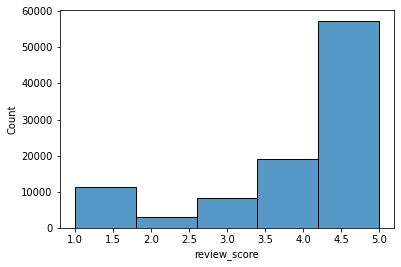

In [3]:
sns.histplot(data["order_reviews"]["review_score"], bins = 5);

❓ Bar chart of `order_status` is plotted<br/>

<Figure size 720x720 with 0 Axes>

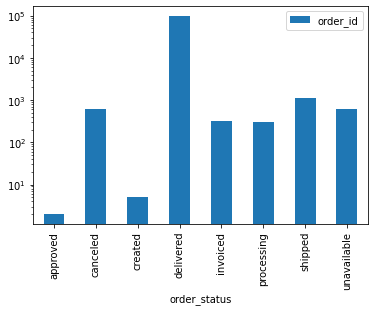

In [4]:
plt.figure(figsize = (10,10))
a = pd.DataFrame(data["orders"].groupby("order_status").count()["order_id"]).plot(kind = "bar")
a.set_yscale("log");

❓ How many of them are delivered ? shipped ? canceled ? ...

In [5]:
orders = data["orders"]

x = [item for item in data["orders"]["order_status"].unique()]
orders = data["orders"]
dict1 = {}

for item in x:
    dict1[item] = orders[orders["order_status"] == item].count()["order_id"]
    
dict1

{'delivered': 96478,
 'invoiced': 314,
 'shipped': 1107,
 'processing': 301,
 'unavailable': 609,
 'canceled': 625,
 'created': 5,
 'approved': 2}

💡 From our data schema, we know - that each `review` has a unique `order`.

🤔 Do all `orders` have a `review`?

<details>
    <summary><i>▸ Details</i></summary>

`pd.Series.isna().sum()` is used to count the number of NaN values in the series
</details>

In [6]:
merged_df = data["orders"].merge(data["order_reviews"], on = "order_id", how = "left")

merged_df["review_id"].isna().sum()

768

The orders that were not reviewed are counted and grouped by `order_status`.

In [7]:
merged_df[merged_df["review_id"].isna() == True].groupby("order_status").size()

order_status
canceled        20
created          2
delivered      646
invoiced         5
processing       6
shipped         75
unavailable     14
dtype: int64

## 2 - Evolution of key business metrics over the past 14 months

## Metrics 

1. Which metric should be used as a `key business output metric`for Olist  📈 ? 
2.  Which metric should be used to measure that a customer had a `good experience with Olist` 🙂 ? 
3. Which metric should be used to measure `shipping delay` 🕗?

For each metric, a trend line is plotted over time.

### Metric 1: Order numbers

❓ The weekly number of total orders per week is plotted (to check how business is going)  


In [8]:
data["orders"]["year_week"] = pd.to_datetime(data["orders"]["order_purchase_timestamp"]).dt.strftime("%Y%U")
total_orders_per_week = pd.DataFrame(data["orders"].groupby(["year_week"]).count()["order_id"]).rename(columns = {"order_id": "number_of_orders"})

total_orders_per_week.head()

,number_of_orders
year_week,
201636,2
201637,2
201640,258
201641,65
201642,1


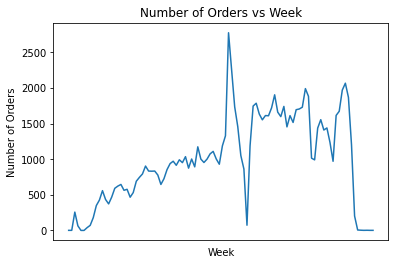

In [9]:
plt.plot(total_orders_per_week)
plt.xticks([])
plt.xlabel("Week")
plt.ylabel("Number of Orders")
plt.title("Number of Orders vs Week");

❓ The weekly number of non-delivered orders is visualised (to check for any potential issues)

In [10]:
potential_issues_orders = data["orders"][data["orders"]["order_status"] != "delivered"].copy()

potential_issues_orders["year_week"] = pd.to_datetime(potential_issues_orders["order_purchase_timestamp"]).dt.strftime("%Y%U")
potential_issues_orders_per_week = pd.DataFrame(potential_issues_orders.groupby(["year_week"]).count()["order_id"]).rename(columns = {"order_id": "number_of_orders"})

potential_issues_orders_per_week.head()

,number_of_orders
year_week,
201636,2
201637,1
201640,47
201641,11
201642,1


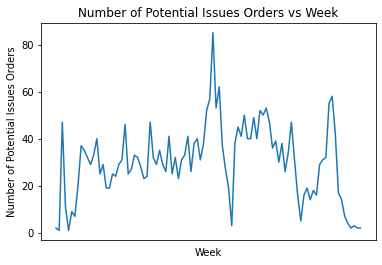

In [11]:
plt.plot(potential_issues_orders_per_week)
plt.xticks([])
plt.xlabel("Week")
plt.ylabel("Number of Potential Issues Orders")
plt.title("Number of Potential Issues Orders vs Week");

### Metric 1-bis (optional): Total payment values
❓ After plotting the total number of orders, the weekly sum of `payment_value` in `BRL` is visualised to approximate Olist's weekly revenues.

💡 The `payments` dataset is merged with the `orders` dataset to collect the date of each payment.

In [12]:
order_merge_payments = data["orders"].merge(data["order_payments"], on = "order_id", how = "left")

⌛️ Datetimes are handled

In [13]:
order_merge_payments["year_week"] = pd.to_datetime(order_merge_payments["order_purchase_timestamp"]).dt.strftime("%Y%U")

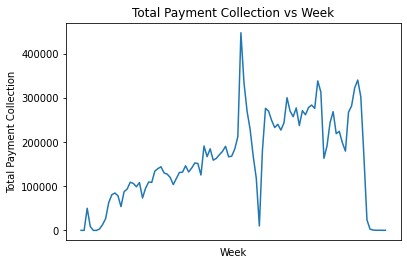

In [14]:
payment_collection_per_week = pd.DataFrame(order_merge_payments.groupby(["year_week"]).sum()["payment_value"])

plt.plot(payment_collection_per_week)
plt.xticks([])
plt.xlabel("Week")
plt.ylabel("Total Payment Collection")
plt.title("Total Payment Collection vs Week");

📈 The number of orders and total amount of payments per week are visualised

In [15]:
orders_merge_payments_per_week = payment_collection_per_week.merge(total_orders_per_week, on = "year_week", how = "outer")

orders_merge_payments_per_week

,payment_value,number_of_orders
year_week,,
201636,211.29,2
201637,40.95,2
201640,50201.28,258
201641,8827.21,65
201642,61.99,1
...,...,...
201836,808.46,4
201837,276.04,2
201838,453.20,3


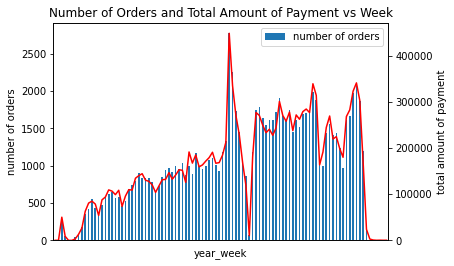

In [16]:
orders_merge_payments_per_week[["number_of_orders"]].plot(kind = "bar")
plt.legend(["number of orders"])
plt.xlabel("week")
plt.ylabel("number of orders")
orders_merge_payments_per_week["payment_value"].plot(secondary_y = True, color = "red")
plt.xticks([])
plt.ylabel("total amount of payment")
plt.ylim(0)
plt.title("Number of Orders and Total Amount of Payment vs Week")
plt.show();

### Metric 2: Customer Satisfaction
❓ How does the `customer satisfaction` evolve on a monthly basis ? The mean average `review_score` is used to illustrate the customer satisfaction.

👉 The`reviews` dataframe is loaded :

In [17]:
order_reviews = data["order_reviews"]

⌛️ Datetime is handled.

In [18]:
order_reviews["year_month"] = pd.to_datetime(order_reviews["review_creation_date"]).dt.strftime("%Y-%m")

📉 The customer satisfaction evolution over time is plotted

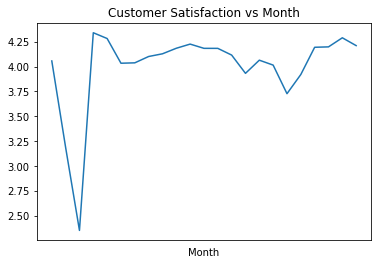

In [19]:
review_score_by_month = order_reviews.groupby("year_month").mean()

plt.plot(review_score_by_month)
plt.xticks([])
plt.xlabel("Month")
plt.title("Customer Satisfaction vs Month")
plt.show();

### Metric 3: Shipping delay

❓Two new metrics, `delay_vs_expected` and `wait_time` are created in ***days***, from the `orders` dataset, and their historical evolution are plotted on a weekly basis to detect trends

<details>
    <summary>▸ <i>Details</i></summary>

🛒 Delivered orders are extracted so that the shipping delays can be computed:

In [20]:
delivered_orders = data["orders"][data["orders"]["order_status"] == "delivered"].copy()

⌛️ Datetime problems are fixed

In [21]:
delivered_orders["order_purchase_timestamp"] = pd.to_datetime(delivered_orders["order_purchase_timestamp"]).dt.date
delivered_orders["order_delivered_customer_date"] = pd.to_datetime(delivered_orders["order_delivered_customer_date"]).dt.date
delivered_orders["order_estimated_delivery_date"] = pd.to_datetime(delivered_orders["order_estimated_delivery_date"]).dt.date

👉 The delay between the actual delivery date and the estimated time of arrival for each order is calculated.

In [22]:
delivered_orders["delay"] = delivered_orders["order_delivered_customer_date"] - delivered_orders["order_estimated_delivery_date"]

👉 The waiting time between the actual delivery date and the moment a customer ordered their items is computed

In [23]:
delivered_orders["wait_time"] = delivered_orders["order_delivered_customer_date"] - delivered_orders["order_purchase_timestamp"]

⌛️ How many orders were delivered later than expected (number and percentage)? <br/>

In [24]:
delivered_orders["delay"] = delivered_orders["delay"].astype('timedelta64[D]')

number_of_late_orders = delivered_orders[delivered_orders["delay"] > 0].count()["order_id"]
number_of_late_orders_percentage = delivered_orders[delivered_orders["delay"] > 0].count()["order_id"]/len(delivered_orders) * 100

In [25]:
number_of_late_orders

6534

In [26]:
number_of_late_orders_percentage

6.77252845208234

* On average, 7% of the orders are delivered after the ETA ⌛️

* The weeks with the worst performance are found 👇
    1. The dataset is aggregated by week
    2. The percentage of orders delivered lately each week was computed

In [27]:
delivered_orders["order_delayed"] = delivered_orders["delay"] > 0

delivered_orders["year_week"] = pd.to_datetime(delivered_orders["order_delivered_customer_date"]).dt.strftime("%Y%U")

aggregate_delayed_orders_per_week = delivered_orders.groupby("year_week").order_delayed.agg(["sum", "mean"]).reset_index()
aggregate_delayed_orders_per_week["delay_percentage"] = aggregate_delayed_orders_per_week["mean"] * 100

📈 The `number of delays` and `percentage of delayed orders` per week are plotted

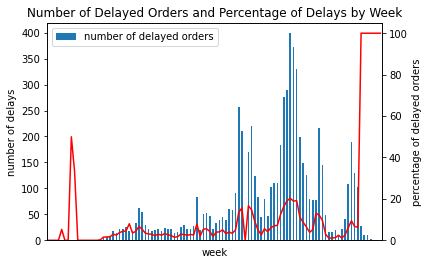

In [28]:
aggregate_delayed_orders_per_week[["sum"]].plot(kind = "bar")
plt.legend(["number of delayed orders"])
plt.xlabel("week")
plt.ylabel("number of delays")
aggregate_delayed_orders_per_week["delay_percentage"].plot(secondary_y = True, color = "red")
plt.xticks([])
plt.ylabel("percentage of delayed orders")
plt.title("Number of Delayed Orders and Percentage of Delays by Week")
plt.ylim(0)
plt.show();

#### Delay Analysis

📈 📉 From the previous graph, Olist experienced major lateness issues on a couple of weeks ⚠️...

👉 These peaks of lateness are investigated.

❓ A dataframe (with weeks as indexes) is created with the following columns:
* number of delays
* number of orders
* percentage of delayed orders

In [29]:
aggregated_delivered_orders_per_week = delivered_orders.groupby("year_week").agg({"order_id": "count", "order_delayed": ["sum", "mean"]})

aggregated_delivered_orders_per_week[('order_delayed',  'mean')] = aggregated_delivered_orders_per_week[('order_delayed',  'mean')] * 100

aggregated_delivered_orders_per_week = aggregated_delivered_orders_per_week.rename_axis(index = "week").rename(columns = {"order_id": "", "order_delayed": "", "count": "number of orders", "sum": "number of delays", "mean": "percentage of delays"})

aggregated_delivered_orders_per_week

number of orders number of delays percentage of delays
week                                                         
201641               48                0             0.000000
201642               67                0             0.000000
201643               68                0             0.000000
201644               40                0             0.000000
201645               19                1             5.263158
...                 ...              ...                  ...
201837               10               10           100.000000
201838                2                2           100.000000
201839                1                1           100.000000
201840                1                1           100.000000
201841                1                1           100.000000

[104 rows x 3 columns]

❓ Sub-dataframes are created to separate these weeks into subgroups of:
- 20% and more
- 15-20%
- 10-15%
- 5-10%
- 5% and less

In [30]:
delay_more_than_20_percent = aggregated_delivered_orders_per_week[aggregated_delivered_orders_per_week["", "percentage of delays"] >= 20]
delay_15_to_20_percent = aggregated_delivered_orders_per_week[(aggregated_delivered_orders_per_week["", "percentage of delays"] >= 15) & (aggregated_delivered_orders_per_week["", "percentage of delays"] < 20)]
delay_10_to_15_percent = aggregated_delivered_orders_per_week[(aggregated_delivered_orders_per_week["", "percentage of delays"] >= 10) & (aggregated_delivered_orders_per_week["", "percentage of delays"] < 15)]
delay_5_to_10_percent = aggregated_delivered_orders_per_week[(aggregated_delivered_orders_per_week["", "percentage of delays"] >= 5) & (aggregated_delivered_orders_per_week["", "percentage of delays"] < 10)]
delay_less_than_5_percent = aggregated_delivered_orders_per_week[aggregated_delivered_orders_per_week["", "percentage of delays"] < 5]